## Create figures

In [1]:
import pandas as pd
import os, json
from scipy.stats import levene, ttest_ind
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import numpy as np
import matplotlib as mpl
from scipy import stats
from Bio import SeqIO
from pathlib import Path
import re
from datetime import datetime
import ast
import warnings
from Bio import Align
import warnings
from Bio import BiopythonParserWarning
warnings.simplefilter('ignore', BiopythonParserWarning)

CONDITIONS = ['no_template', 'template_single_seq', 'template_MSA']
RESULT_DIR = 'output'
#RESULT_DIR = 'raw_data/30-08-2023_FixDomainsWithAF_v3/output/'
CACHE_DIR = 'tmp'
FIGURES_DIR = 'figures'
#DATA_DIR = 'raw_data/30-08-2023_FixDomainsWithAF_v3/data/'
DATA_DIR = 'data'
PROT1 = "A0A426UPE9"
PROT2 = "U1LSP8"
DOMAIN1 = "PF02369"
DOMAIN2 = "PF09534"

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

aligner = Align.PairwiseAligner()
aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")

def collect_db_info(database_res_dir: str) -> pd.DataFrame:
    """Collect pfam and af2 databases info"""
    
    # some lines contain 2 or more proteins, fix it
    with open(os.path.join(database_res_dir, 'target_proteins.tsv'), 'r') as handle:
        text_to_fix = handle.readlines()
    fixed_text = "".join(text_to_fix).replace(' PF', '\nPF')
    with open(os.path.join(CACHE_DIR, 'target_proteins.tsv'), 'w') as handle:
        handle.write(fixed_text)

    protein_info = pd.read_table(os.path.join(CACHE_DIR, 'target_proteins.tsv'), sep=' ')
    protein_info['seq_lenght'] = [len(sequence) for sequence in protein_info.sequence]
    
    # safety check
    check = len(protein_info[protein_info.seq_end > protein_info.seq_lenght])
    assert  check == 0,\
          f"{check} proteins have upper domain boundary longer than protein lenght"
        
    
    return protein_info

def p_value_assign(p_value:float, n:float) -> str:
    """N is numerosity for bonferroni correction"""
    if p_value < 0.001 / n:
        return '***'
    elif p_value < 0.01 / n:
        return '**'
    elif p_value < 0.05 / n:
        return '*'
    else:
        return 'ns'

def nice_plot2(plot_df: pd.DataFrame, feature: str, ax: plt.axis, low_value: float,
              inspacer: float, interspacer: float, alpha=0.05, mspace=0, stat=True, color='C0', condition_pairs=
              [['no_template', 'best_pick'], ['no_template', 'template_single_seq'], 
               ['no_template', 'template_MSA']], 
               conditions=['no_template', 'template_MSA', 'template_single_seq', 'best_pick']) -> None:
    
    """Nice sns boxplot with scatter to plot features dependent on AF2 running condition
    plots stats on top of the plot using student t-test if levene test for variance homogenety is non
    significant, alteratevely, welch's t-test is used.

    plot_df    : dataframe with condition data. Naming must be consistent with mapping dic
    feature    : plot_df column with feature to plot
    ax         : plt.axis
    low_value  : first value to plot stat bracket
    inspacer   : stat bracket margin depth
    interspace : space with next stat bracket
    alpha      : alpha of scatter
    mspace     : space to add on top of 98 percentile to plot mean
    stat       : should plot stat? (True) 
    color      : color of bar
    condition_pars : set of conditon pairs to consider for stat and for plotting [[cond1, cond2], [cond3, cond4], ...]
    conditions: ['no_template', 'template_MSA', 'template_single_seq', 'best_pick']
    """

    
    plot_df = plot_df[plot_df.condition.isin([_ for cond in condition_pairs for _ in cond])].copy()
    # give nicer names
    condition_mapper = {'no_template': 'no template-MSA', 'template_MSA': 'template-MSA',
        'template_single_seq': 'template-single seq', 'best_pick': 'best pick'}
    conditions = [condition_mapper[condition] for condition in conditions]
    plot_df['condition'] = plot_df.condition\
        .replace(condition_mapper)
    plot_df['condition'] = plot_df['condition'].astype('category')
    plot_df['condition'] = plot_df['condition'].cat.set_categories(conditions)
    condition_pairs = [[condition_mapper[cond[0]], condition_mapper[cond[1]]] for cond in condition_pairs]
    
    
    g = sns.barplot(plot_df, y=feature, x='condition', alpha=0.5, color=color, errorbar='sd', orient='v', ax=ax)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)

    #g = sns.stripplot(data=plot_df, y=feature, x='condition', color='black', alpha=alpha, 
    #jitter=.25,
    #legend=False)

    # plot mean values
    vertical_offset = plot_df[feature].quantile(.99) + mspace# offset from median for display

    for condition in conditions:
        mean = plot_df[plot_df['condition'] == condition][feature].mean().round(2)
        pos = [pos for label, pos in zip([tick.get_text() for tick in ax.get_xticklabels()], ax.get_xticks())\
                if label == condition][0]

        g.text(pos, vertical_offset, f'{mean}', 
                horizontalalignment='center',color='black')

    # add statictical annotations
    if stat:
        equal_var = True
        levene_test =[]
        for condition_pair in condition_pairs:
            levene_test.append(levene(plot_df[plot_df.condition == condition_pair[0]][feature],
                plot_df[plot_df.condition == condition_pair[1]][feature])[1])
        if any(levene_test) < .05:
            equal_var = False
            print(f'Setting equal_var: {False}')

        # bonferroni correction
        n = len(condition_pairs)

        up_value = low_value + inspacer
        for conditions in condition_pairs:
            # get xtick positions
            pos1 = [pos for label, pos in zip([tick.get_text() for tick in ax.get_xticklabels()], ax.get_xticks())\
                if label == conditions[0]][0]
            pos2 = [pos for label, pos in zip([tick.get_text() for tick in ax.get_xticklabels()], ax.get_xticks())\
                if label == conditions[1]][0]
            
            # p value
            p_value = (ttest_ind(plot_df[plot_df.condition == conditions[0]][feature].to_list(),
                plot_df[plot_df.condition == conditions[1]][feature].to_list(), equal_var=equal_var))[1]
            
            # plot
            if p_value < 0.05 / n:
                ax.plot([pos1, pos1, pos2, pos2], [low_value, up_value, up_value, low_value], lw=1.5, color='black', alpha=.5)
                ax.text((pos1+pos2)*.5, up_value, p_value_assign(p_value, n), ha='center', va='bottom', alpha=.5)
                
                low_value, up_value, up_value, low_value = [low_value + interspacer, up_value + interspacer,
                                                            up_value + interspacer, low_value + interspacer]
    
    return None

def get_best_condition(df: pd.DataFrame, feature:str) -> pd.DataFrame:
    """Get condition by which the protein is the best (plddt normally). Not suitable for domain_plddt
    df: dataframe which should contain 'condition' column with {'no_template', 'template_MSA', 'template_single_seq'}
        and should contain 'uniprot_acc', 'pfamA_acc and feature
    feature: database column to use for selction. max() will be applied
    """

    condition_index = df.columns.get_loc('condition')

    outlist = []
    iter_df = df[['uniprot_acc', 'pfamA_acc']].drop_duplicates()
    for uniprot_acc, pfamA_acc in zip(iter_df.uniprot_acc.to_list(), iter_df.pfamA_acc.to_list()):
        
        # exclude case of no templates
        if len(df[(df.uniprot_acc == uniprot_acc) & (df.pfamA_acc == pfamA_acc) & (df.condition == 'template_single_seq')]) > 0 and\
            len(df[(df.uniprot_acc == uniprot_acc) & (df.pfamA_acc == pfamA_acc) & (df.condition == 'template_MSA')]) > 0:
            
            # get condition in which the structure is the best
            protein_condition = 'template_single_seq'
            if df[(df.uniprot_acc == uniprot_acc) &\
                    (df.pfamA_acc == pfamA_acc) &\
                    (df.condition == 'template_MSA')][feature].unique()[0] > \
                df[(df.uniprot_acc == uniprot_acc) &\
                    (df.pfamA_acc == pfamA_acc) &\
                    (df.condition == 'template_single_seq')][feature].unique()[0]:
                
                protein_condition = 'template_MSA'
            
            best_values = df[(df.uniprot_acc == uniprot_acc) &\
                                (df.pfamA_acc == pfamA_acc) &\
                                (df.condition == protein_condition)].values[0]
            condition = "best_pick"
            
            best_values[condition_index] = condition
            outlist.append(list(best_values))
        
    return pd.concat([df, pd.DataFrame(outlist, columns=df.columns.to_list())])

def get_log_data_wo_relaxation(logfile: str) -> pd.DataFrame():
    """Get recycle time and relaxation time from colabfold logfiles
    logfile: str: path/to/logfile.txt
    """

    logfile = open(logfile, 'r').readlines()
    
    query_p = re.compile("Query [0-9]{1,9}/[0-9]{1,9}: [A-Z0-9]{4,20}")
    log_time_p = re.compile("[0-9]{4}-[0-9]{2}-[0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2},[0-9]{3}")
    final_time_p = re.compile("took [0-9]{1,5}.[0-9]s")
    recycle_p = re.compile("recycle=[0-9]{1,2}")
    plddt_p = re.compile("pLDDT=[0-9]{2}\.{0,1}[0-9]{0,2}")
    ptm_p = re.compile("pTM=[0-1]\.[0-9]{0,3}")
    tol_p = re.compile("tol=[0-9]{1,3}\.{0,1}[0-9]{0,3}")

    outlist = []
    for index, line in enumerate(logfile):
        
        if 'Query' in line:
            uniprot_acc = query_p.findall(line)[0].split()[-1]
            model = 0
        
        if 'recycle=0' in line:
            previous_timestep = log_time_p.findall(logfile[index-1])[0]
            previous_timestep = datetime.strptime(previous_timestep, '%Y-%m-%d %H:%M:%S,%f')
            timestep = log_time_p.findall(line)[0]
            timestep = datetime.strptime(timestep, '%Y-%m-%d %H:%M:%S,%f')
            delta_t = (timestep-previous_timestep).total_seconds()
            plddt = float(plddt_p.findall(line)[0].split("=")[-1])
            ptm = float(ptm_p.findall(line)[0].split("=")[-1])
            outlist.append([uniprot_acc, 0, plddt, ptm, None, delta_t, model])

        if 'alphafold2_ptm_model_' in line and 'recycle=' in line and 'recycle=0' not in line:
            previous_timestep = timestep
            timestep = log_time_p.findall(line)[0]
            timestep = datetime.strptime(timestep, '%Y-%m-%d %H:%M:%S,%f')
            delta_t = (timestep-previous_timestep).total_seconds()
            recycle = int(recycle_p.findall(line)[0].split("=")[-1])
            plddt = float(plddt_p.findall(line)[0].split("=")[-1])
            ptm = float(ptm_p.findall(line)[0].split("=")[-1])
            tol = float(tol_p.findall(line)[0].split("=")[-1])

            outlist.append([uniprot_acc, recycle, plddt, ptm, tol, delta_t, model])

        #if 'took' in line and 'Relaxation' not in line:
        #    final_time = float(final_time_p.findall(line)[0].split()[-1].replace('s', ''))
        if 'recycle=5' in line:
            model +=1
    
    return pd.DataFrame(outlist, columns = ['uniprot_acc', 'recycle', 'plddt', 'ptm', 'tol', 'delta_t', 'model'])

def get_domains_from_log(logpath: str, uniprot_acc) -> list:
    """Get tmeplate codes from logfile"""

    query_re = re.compile("Query [0-9]{0,3}/[0-9]{0,3}: " + uniprot_acc)
    templates_re = re.compile("Sequence [0-9]{0,3} found templates: ")
    found = False
    for line in open(logpath, 'r').readlines():
        if query_re.findall(line):
            found = True
        if templates_re.findall(line) and found == True:
            templates = ast.literal_eval(line.split(': ')[-1])
            return templates

def align_seqs(query:str, target:str, aligner=aligner) -> float:

    """Runs global sequence alignemnt and returns % of identity of query with target.
    Considers alignment with highest score

    param: query: query sequence
    param: target: target sequence
    aligner: Bio.Align.PairwiseAligner
    output: % of identity query-target in respect to query
    """
    aligner.mode = 'global'
    alignments = aligner.align(query, target)
    alignment = alignments[0]

    return round(alignment.counts().identities / len(query), 2)*100

In [2]:
protein_info = collect_db_info(os.path.join(RESULT_DIR, 'DB_query'))
AF2_df = pd.read_csv(os.path.join(RESULT_DIR, 'summary_results', 'AF2Results.csv'))
df_xhpi = pd.read_csv(os.path.join(RESULT_DIR, 'summary_results', 'xhpi_results.csv'))
df_rank = pd.read_csv(os.path.join(RESULT_DIR, 'summary_results', 'af2Rank_results.csv'))
df_rama = pd.read_csv(os.path.join(RESULT_DIR, 'summary_results', 'ramachandran_results.csv'))
afdb_info = pd.read_csv(os.path.join(DATA_DIR, "afdb_protein_info.csv"))
AF2_df['plddt_class'] = 'Very low'
AF2_df.loc[AF2_df.uniprot_acc.isin(AF2_df[(AF2_df.plddt > 50) & (AF2_df.condition == 'no_template')].uniprot_acc.unique()),
'plddt_class'] = 'Low'
AF2_df.loc[AF2_df.uniprot_acc.isin(AF2_df[(AF2_df.plddt > 70) & (AF2_df.condition == 'no_template')].uniprot_acc.unique()),
'plddt_class'] = 'Confident'
AF2_df.loc[AF2_df.uniprot_acc.isin(AF2_df[(AF2_df.plddt > 90) & (AF2_df.condition == 'no_template')].uniprot_acc.unique()),
'plddt_class'] = 'Very high'

In [3]:
# plot params
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['axes.titleweight'] = 'bold'
ANNOT_FONT_SIZE = 50 # size of letters that specify images

## Create paper images


## Figure 1

In [4]:
# generate distributions

with open(os.path.join(DATA_DIR, 'distributions.json'), 'r') as handle:
    dist_dic = json.load(handle)
# normalize values
for pfam_id in dist_dic.keys():
    total = total = sum(dist_dic[pfam_id])
    dist_dic[pfam_id] = [dist_dic[pfam_id][i] / total for i in range(100)]

dist_df = pd.DataFrame(dist_dic).T

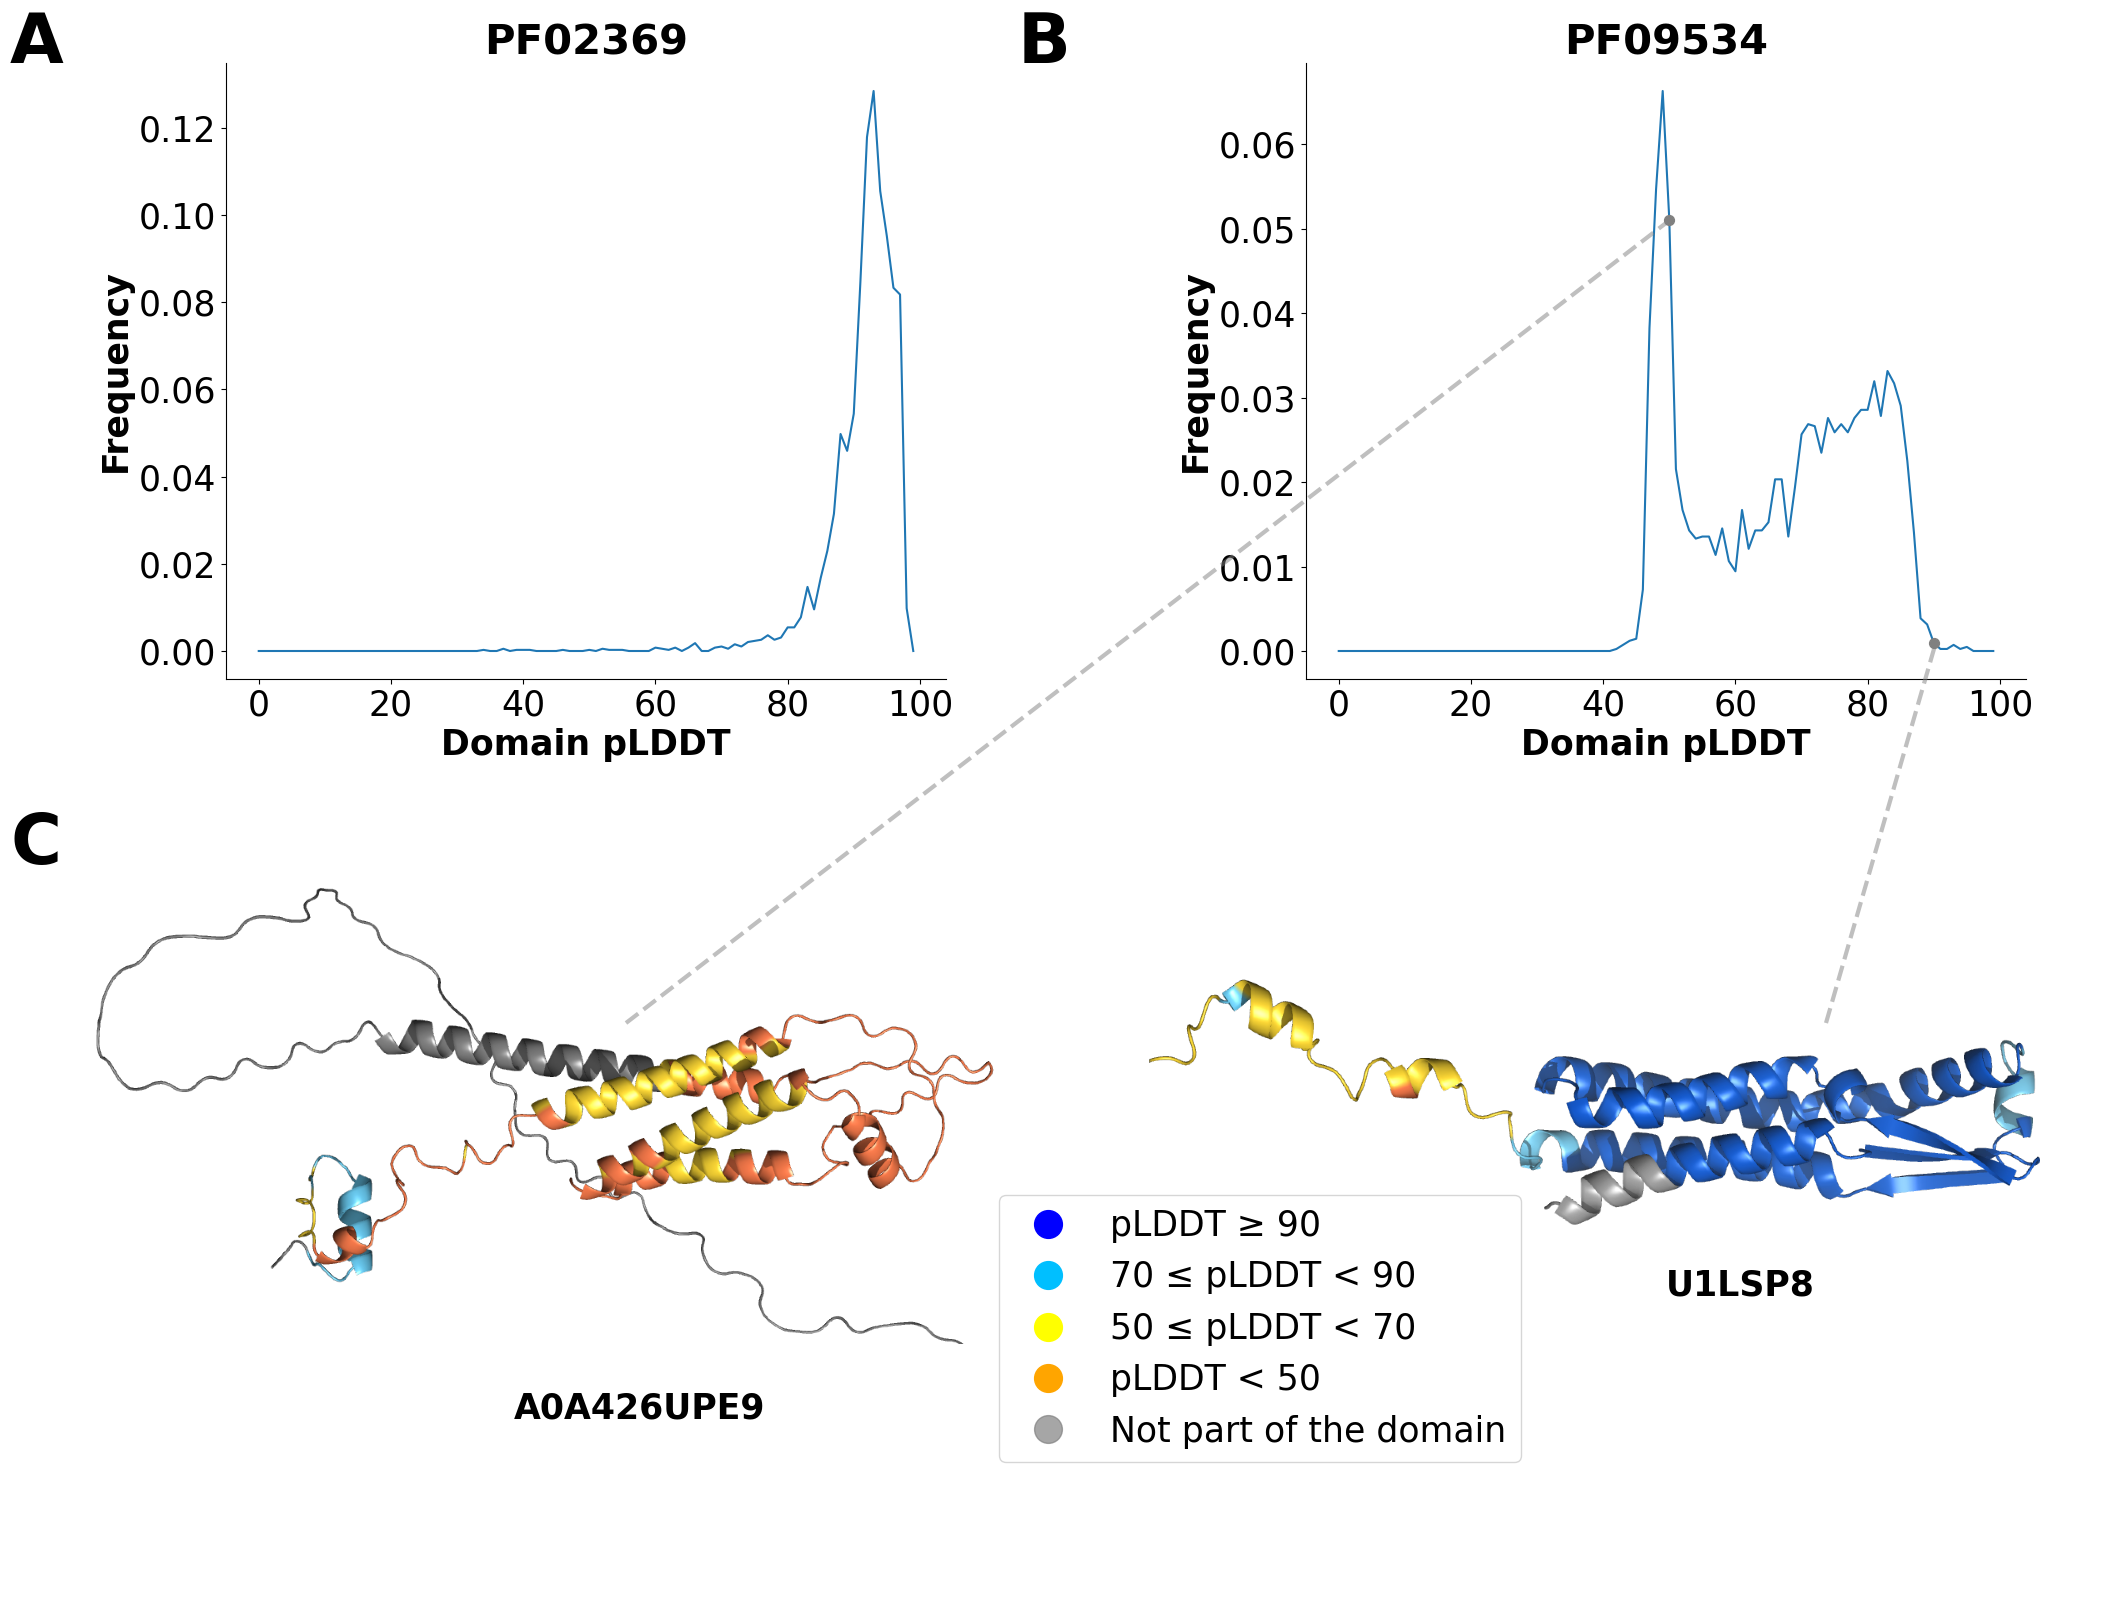

In [21]:
fig, ax = plt.subplots(2,2, figsize=[20,20])
plt.subplots_adjust(hspace=.5, 
                    wspace=.5,
                    left=0,
                    right=.9)
plt.text(-1.8,2.5, "A", weight="bold", fontsize=ANNOT_FONT_SIZE)
plt.text(-.4,2.5, "B", weight="bold", fontsize=ANNOT_FONT_SIZE)
plt.text(-1.8,1.2, "C", weight="bold", fontsize=ANNOT_FONT_SIZE)
#plt.text(-.4,1.2, "D", weight="bold", fontsize=ANNOT_FONT_SIZE)

#1
pfam_id = DOMAIN1
ax[0,0].plot(dist_df.loc[pfam_id])
ax[0,0].set_title(pfam_id)
ax[0,0].set_xlabel('Domain pLDDT')
ax[0,0].set_ylabel('Frequency')
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

#2
pfam_id = DOMAIN2
U1LSP8_domain_plddt = round(afdb_info[(afdb_info.alphafold_id.str.contains(PROT1)) & (afdb_info.pfam_id == pfam_id)].dom_score)
A0A426UPE9_domain_plddt = round(afdb_info[(afdb_info.alphafold_id.str.contains(PROT2)) & (afdb_info.pfam_id == pfam_id)].dom_score)

# plot distribution
ax[0,1].plot(dist_df.loc[pfam_id])
# plot domains
x = [U1LSP8_domain_plddt, A0A426UPE9_domain_plddt]
y = [dist_df.loc[pfam_id][U1LSP8_domain_plddt], dist_df.loc[pfam_id][A0A426UPE9_domain_plddt]]
ax[0,1].scatter(x, y, s=50, c='grey', zorder=2, alpha=1)
ax[0,1].set_title(pfam_id)
ax[0,1].set_xlabel('Domain pLDDT')
ax[0,1].set_ylabel('Frequency')
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

# add outside lines
x,y = np.array([[.2, 0.72], [.4, 0.8]])
line = Line2D(x, y, color='grey', alpha=.5, lw=3, ls="--")
fig.add_artist(line)

x,y = np.array([[.8, 0.855], [.4, 0.5905]])
line = Line2D(x, y, color='grey', alpha=.5, lw=3, ls="--")
fig.add_artist(line)

#3
ax[1,0].axis('off')
arr_img = plt.imread(os.path.join(DATA_DIR, f"{PROT1}.png"))
im = OffsetImage(arr_img, zoom=.6)
ab = AnnotationBbox(im, (.45,.8), bboxprops=dict(color="white"))
ax[1,0].add_artist(ab)
ax[1,0].text(.4,.3, PROT1, weight="bold")

#4
ax[1,1].axis('off')
arr_img = plt.imread(os.path.join(DATA_DIR, f"{PROT2}.png"))
im = OffsetImage(arr_img, zoom=.57)
ab = AnnotationBbox(im, (.43, .8), bboxprops=dict(color="white"))
ax[1,1].add_artist(ab)

ax[1,1].text(.5,.5, PROT2, weight="bold")

# add legend
ms = 20
handles = [
    plt.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=ms),
    plt.Line2D([], [], color='deepskyblue', marker='o', linestyle='None', markersize=ms),
    plt.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=ms),
    plt.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=ms),
    plt.Line2D([], [], color='grey', marker='o', linestyle='None', markersize=ms, alpha=0.7)
]
labels = ['pLDDT ≥ 90', '70 ≤ pLDDT < 90', '50 ≤ pLDDT < 70', 'pLDDT < 50', 'Not part of the domain']
legend = ax[1,1].legend(handles, labels, loc='lower left', 
                   frameon=True, facecolor=None, ncol=1, bbox_to_anchor=(-0.45,.2),
                   )
legend.set_title('')

plt.savefig(os.path.join(FIGURES_DIR, 'figure1.png'), dpi=190,  transparent=False, bbox_inches='tight')

plt.show()

## Figure 2

In [5]:
# read in template data
if os.path.isfile(os.path.join(CACHE_DIR, 'similarity.csv')) == False:

    result_dir = os.path.join(RESULT_DIR,'AF2')
    input_dir = os.path.join(RESULT_DIR,'AF2')
    outlist = []
    for condition in ['template_MSA']:
        for domain in filter(lambda x: x.startswith('PF'),  os.listdir(os.path.join(result_dir, condition))):
            template_mapper = None
            try:
                with open(os.path.join(input_dir, 'templates', domain, '.mapper.json'), 'r') as fp:
                    template_mapper = json.load(fp)
                template_mapper_lookup = {v: k for k, v in template_mapper.items()}
            except Exception as e:
                print(domain, e)
            if template_mapper != None:

                for file in filter(lambda x: '_relaxed_rank_001' in x and x.endswith('.pdb'),
                                os.listdir(os.path.join(result_dir, condition, domain))):
                    logpath = os.path.join(result_dir, condition, domain, 'log.txt')
                    uniprot_acc = file.split('_')[0] 
                    templates = get_domains_from_log(logpath, uniprot_acc)
                    for template in templates:
                        template_code = template.split('_')[0]
                        template = os.path.join(input_dir, 'templates', domain, template_code + '.cif')
                        target = str(list(SeqIO.parse(template, "cif-atom"))[0].seq)
                        query = str(list(SeqIO.parse(os.path.join(result_dir, condition, domain, file), 'pdb-atom'))[0].seq)
                        seq_identity = align_seqs(query, target)
                        outlist.append([condition, domain, uniprot_acc, template_mapper_lookup[template_code].split('_')[0], seq_identity])   
                        if uniprot_acc == template_mapper_lookup[template_code].split('_')[0]:
                            #print(uniprot_acc, template_mapper_lookup[template_code].split('_')[0], seq_identity)     
                            assert seq_identity >= 100, f"Seq identity is wrong, {uniprot_acc} {seq_identity}"      

    id_df = pd.DataFrame(outlist, columns=['condition', 'pfamA_acc', 'uniprot_acc', 'template_acc', 'seq_identity'])
    del id_df['condition']  
    id_df.to_csv(os.path.join(CACHE_DIR, 'similarity.csv'), index = False)
else:
    id_df = pd.read_csv(os.path.join(CACHE_DIR, 'similarity.csv'))
            

/var/folders/1j/ygnms5_x079_fzx5qvk_zmnh0000gp/T/ipykernel_31050/2716357860.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(ax[0,0].get_xticklabels(),rotation=30)
/var/folders/1j/ygnms5_x079_fzx5qvk_zmnh0000gp/T/ipykernel_31050/2716357860.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_df['plddt_delta'] = left_df['plddt'] - right_df['plddt']
/var/folders/1j/ygnms5_x079_fzx5qvk_zmnh0000gp/T/ipykernel_31050/2716357860.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

(-41.0, 61.0)

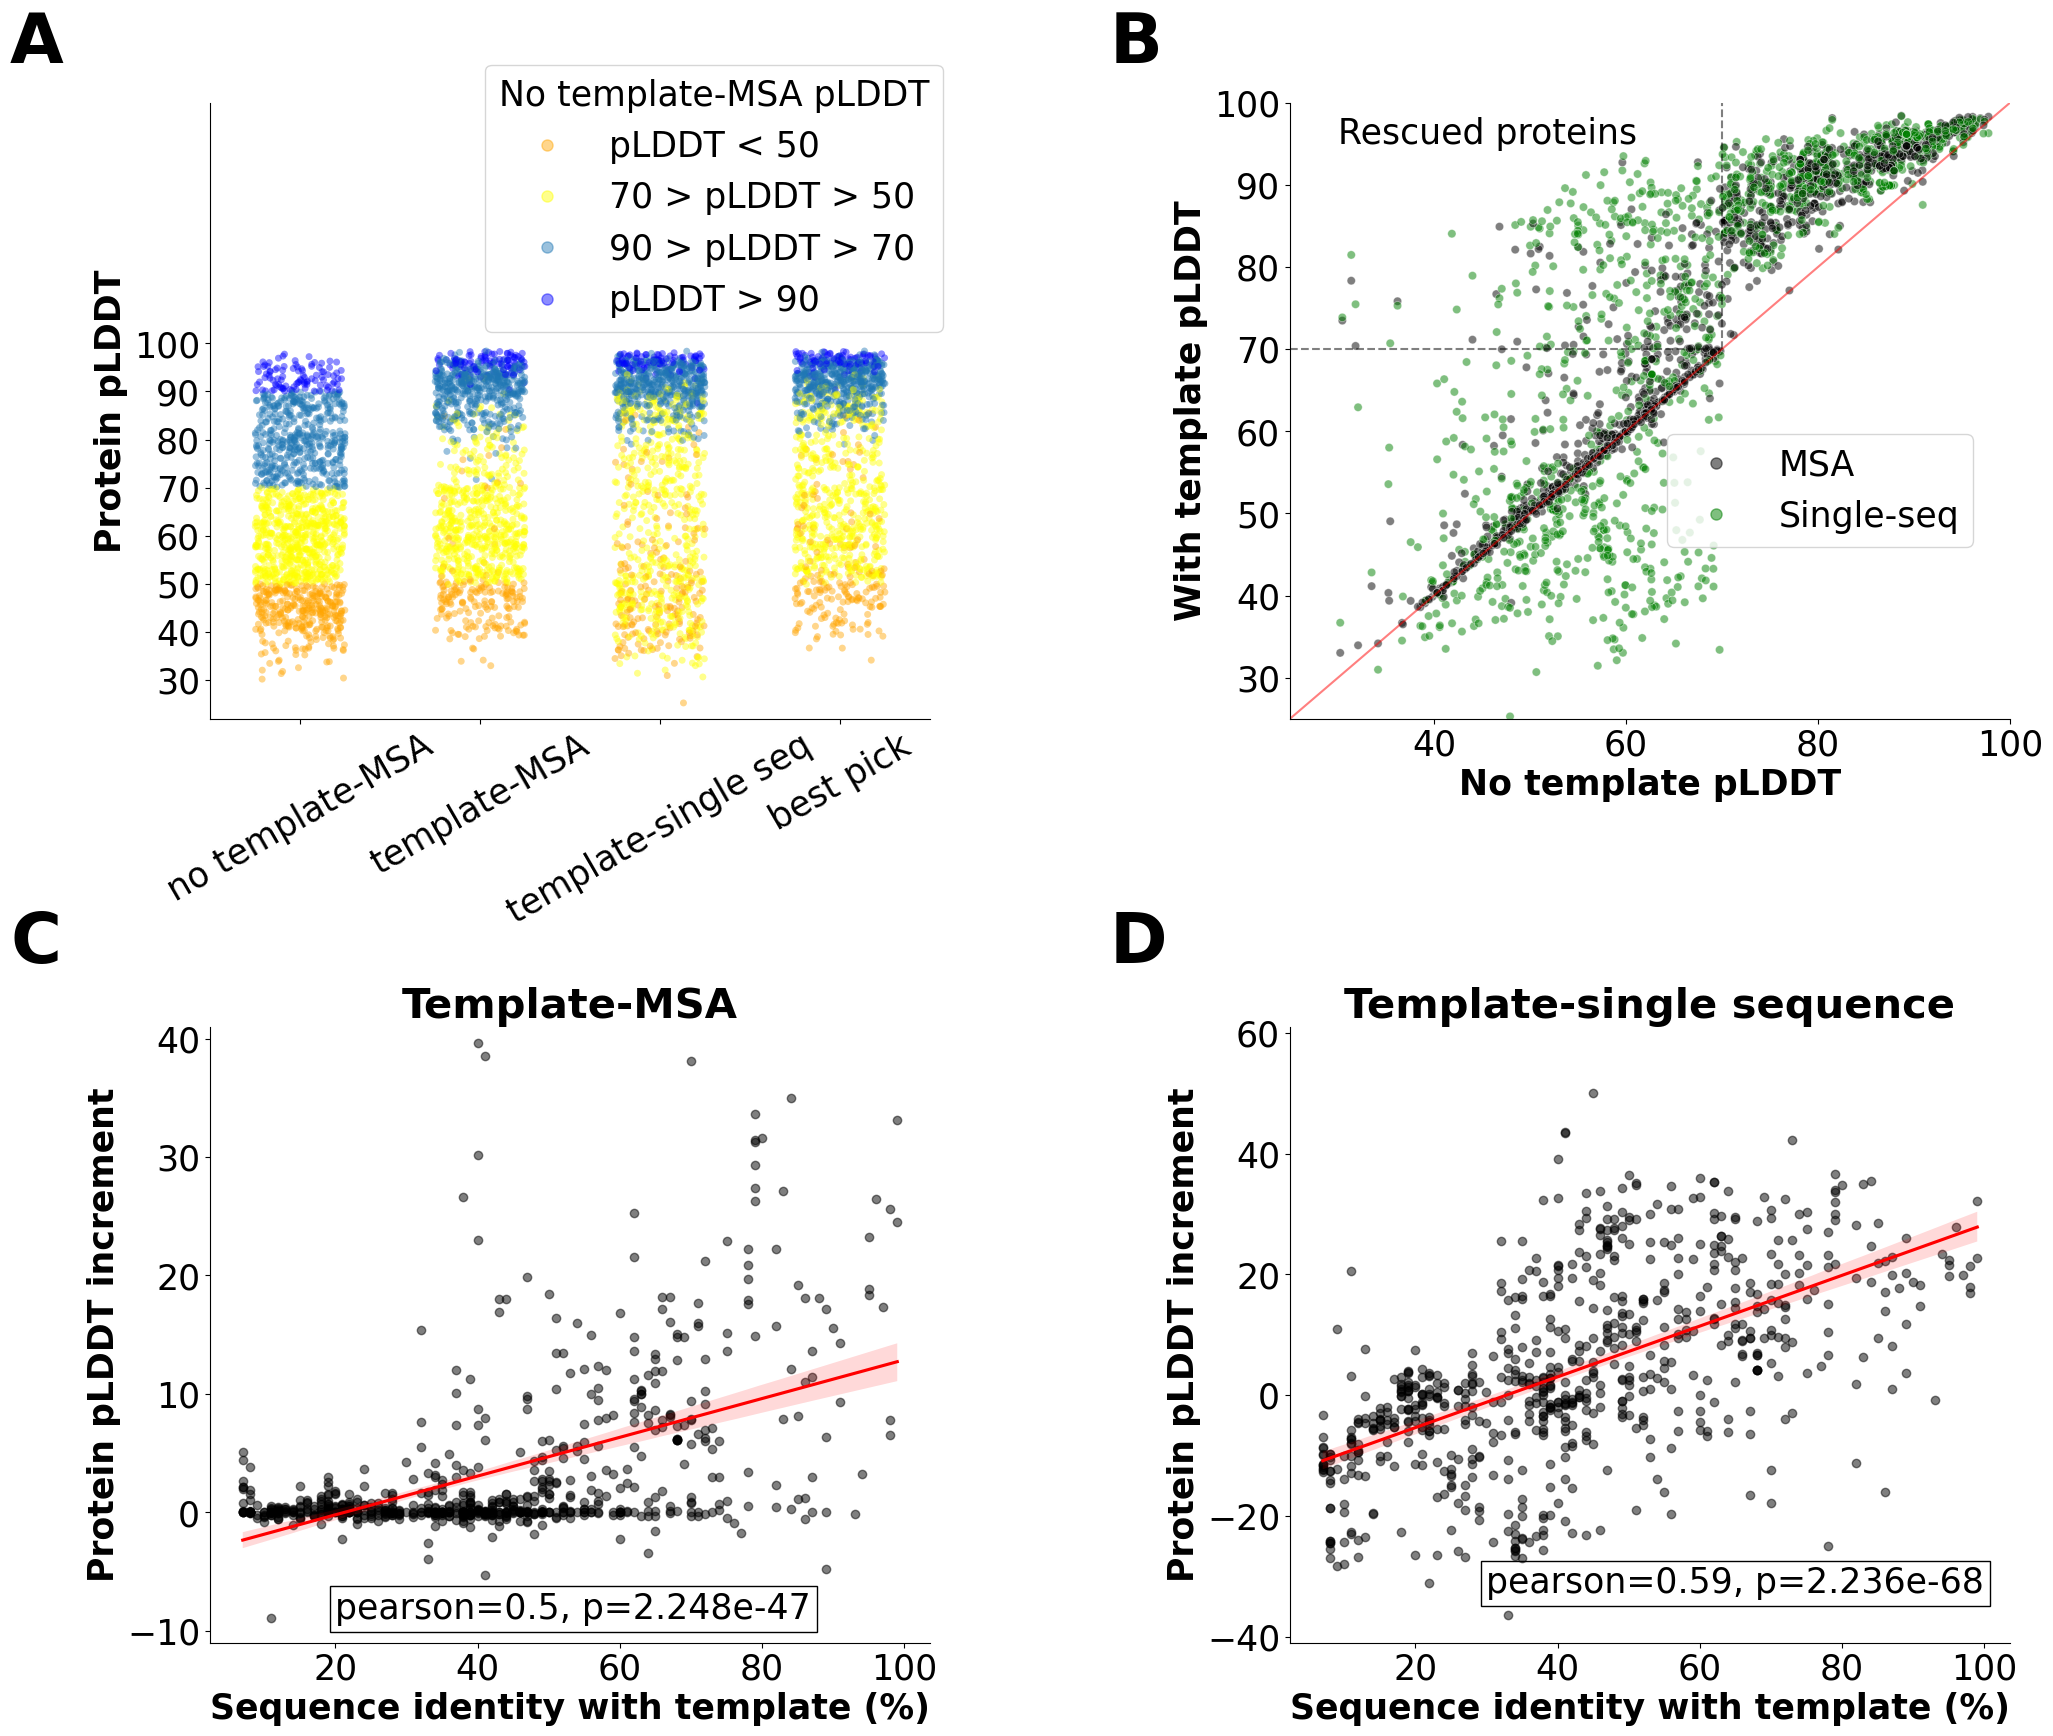

In [59]:
ms = 8
fig, ax = plt.subplots(2,2, figsize=[20,20])
plt.subplots_adjust(hspace=.5, 
                    wspace=.5,
                    left=0,
                    right=.9)
fig.text(-0.1,.9, "A", weight="bold", fontsize=ANNOT_FONT_SIZE)
fig.text(.45,0.9, "B", weight="bold", fontsize=ANNOT_FONT_SIZE)
fig.text(-0.1,0.45, "C", weight="bold", fontsize=ANNOT_FONT_SIZE)
fig.text(0.45,0.45, "D", weight="bold", fontsize=ANNOT_FONT_SIZE)

#1
plot_df = AF2_df[['uniprot_acc', 'condition', 'plddt', 'plddt_class']].drop_duplicates()
plot_df = plot_df[plot_df.condition.isin(['no_template', 'template_MSA', 'template_single_seq', 
                                          'best_pick_structure_plddt'])]

plot_df.condition = plot_df.condition.replace({'no_template': 'no template-MSA', 'template_MSA': 'template-MSA',
        'template_single_seq': 'template-single seq', 'best_pick_structure_plddt': 'best pick'})

plot_df['condition'] = plot_df['condition'].astype('category')
plot_df['condition'] = plot_df['condition'].cat.set_categories(
    ['no template-MSA', 'template-MSA', 'template-single seq', 'best pick'])


g = sns.stripplot(data=plot_df, y='plddt', x='condition', hue='plddt_class', color='black', alpha=.45, 
                  jitter=.25, hue_order=['Very low', 'Low', 'Confident', 'Very high'],
                  palette={'Very low': 'orange', 'Low': 'yellow', 'Confident':'C0', 'Very high': 'blue'}, legend=False,
                  dodge=False, ax=ax[0,0])
g.set_xticklabels(ax[0,0].get_xticklabels(),rotation=30)

ax[0,0].set_ylabel('Protein pLDDT')
ax[0,0].set_xlabel('')
ax[0,0].set_yticks([i for i in range(20, 110, 10)])
ax[0,0].set_ylim([22, 150])
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

handles = [
    plt.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=ms, alpha=.45),
    plt.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=ms, alpha=.45),
    plt.Line2D([], [], color='C0', marker='o', linestyle='None', markersize=ms, alpha=.45),
    plt.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=ms, alpha=.45),
    ]
labels = ['pLDDT < 50', '70 > pLDDT > 50', '90 > pLDDT > 70', 'pLDDT > 90']
legend = ax[0,0].legend(handles, labels, 
                   frameon=True, facecolor=None, ncol=1, bbox_to_anchor=(0.7,0.6), loc="lower center"
                   )
legend.set_title('No template-MSA pLDDT')

#2
plot_df = pd.merge(AF2_df[AF2_df.condition=='no_template'][['pfamA_acc', 'uniprot_acc', 'plddt', 'condition']].drop_duplicates()\
                   .rename(columns={'plddt': 'no_template-plddt'}),
                   AF2_df[AF2_df.condition.isin(['template_single_seq', 'template_MSA'])][['pfamA_acc', 'uniprot_acc', 'plddt', 'condition']]\
                   .drop_duplicates(), 
                   on= ['pfamA_acc', 'uniprot_acc'])

plot_df.condition_y = plot_df.condition_y.replace({'template_single_seq': 'Single seq', 
                                                  'template_MSA': 'MSA'})
plot_df = plot_df.rename(columns={'condition_y': 'condition'})

g = sns.scatterplot(plot_df, x='no_template-plddt', y='plddt', hue='condition', 
                palette={'MSA': 'black', 'Single seq': 'green'}, alpha=.5, ax=ax[0,1], legend=False)
handles = [
    plt.Line2D([], [], color='black', marker='o', linestyle='None', markersize=ms, alpha=.5),
    plt.Line2D([], [], color='green', marker='o', linestyle='None', markersize=ms, alpha=.5)
    ]
labels = ['MSA', 'Single-seq']
legend = ax[0,1].legend(handles, labels, loc='lower left', 
                   frameon=True, facecolor=None, ncol=1, bbox_to_anchor=(0.5,.25),
                   )
legend.set_title('')

ax[0,1].set_xlim([25,100])
ax[0,1].set_ylim([25,100])
ax[0,1].set_ylabel('With template pLDDT')
ax[0,1].set_xlabel('No template pLDDT')
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

# add dotted lines
ax[0,1].vlines(x=70, ymin=70, ymax=100, color='black', linestyles='dashed', alpha=.5)
ax[0,1].hlines(y=70, xmin=25, xmax=70, color='black', linestyles='dashed', alpha=.5)
ax[0,1].axvspan(xmin=25,xmax=70, ymin=70, facecolor='green', alpha=0.2)
#plt.axhspan(25,70, facecolor='white', alpha=1)
ax[0,1].text(x=30, y=95, s='Rescued proteins')

# add red line
X_plot = np.linspace(0, 100, 100)
Y_plot = X_plot

ax[0,1].plot(X_plot, Y_plot, color='red', alpha=.5)

#3
# consider only improvable proteins and protein found in all conditions
improvable_proteins = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70)]\
    .uniprot_acc.unique()
uniprot_accs = [uniprot_acc for uniprot_acc in improvable_proteins if uniprot_acc in 
                AF2_df[AF2_df.condition == 'no_template'].uniprot_acc.to_list() and uniprot_acc in
                AF2_df[AF2_df.condition == 'template_single_seq'].uniprot_acc.to_list() and
                AF2_df[AF2_df.condition == 'template_MSA'].uniprot_acc.to_list()]

plot_df = id_df.groupby(['pfamA_acc','uniprot_acc']).max()
plot_df = plot_df.reset_index()

plot_df = pd.merge(plot_df, AF2_df[(AF2_df.condition == 'template_MSA')]\
                   [['pfamA_acc', 'uniprot_acc', 'plddt']].drop_duplicates(),
          on=['pfamA_acc', 'uniprot_acc'])
plot_df = plot_df[plot_df.uniprot_acc.isin(uniprot_accs)]

# get plddt delta
delta_df = AF2_df[(AF2_df.uniprot_acc.isin(uniprot_accs))]\
                    [['pfamA_acc', 'uniprot_acc', 'condition', 'plddt']].drop_duplicates()
delta_df.condition = delta_df.condition.replace({'best_pick_structure_plddt': 'best_pick'})
delta_df = delta_df.set_index(['pfamA_acc', 'uniprot_acc'])
left_df, right_df = delta_df[delta_df.condition == 'template_MSA'].align(delta_df[delta_df.condition == 'no_template'])
delta_df = left_df[[]]
delta_df['plddt_delta'] = left_df['plddt'] - right_df['plddt']
delta_df = delta_df.reset_index()

plot_df = pd.merge(plot_df, delta_df, on=['pfamA_acc', 'uniprot_acc'])
_ = sns.regplot(x='seq_identity', y='plddt_delta', data=plot_df, ci=95, ax = ax[1,0],
                scatter_kws={'alpha':0.5, 'color': 'black'},
                line_kws={'color':"r"})
r, p = stats.pearsonr(plot_df.seq_identity, plot_df.plddt_delta)
ax[1,0].text(x=20,y=-9,s='pearson={:0.2}, p={:0.3e}'.format(r, p),
             bbox=dict(facecolor='none', edgecolor='black'))

ax[1,0].set_ylabel('Protein pLDDT increment')
ax[1,0].set_xlabel('Sequence identity with template (%)')
ax[1,0].set_title('Template-MSA')
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].set_ylim([-11, 41])

#4
improvable_proteins = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70)]\
    .uniprot_acc.unique()
uniprot_accs = [uniprot_acc for uniprot_acc in improvable_proteins if uniprot_acc in 
                AF2_df[AF2_df.condition == 'no_template'].uniprot_acc.to_list() and uniprot_acc in
                AF2_df[AF2_df.condition == 'template_single_seq'].uniprot_acc.to_list() and
                AF2_df[AF2_df.condition == 'template_MSA'].uniprot_acc.to_list()]

plot_df = id_df.groupby(['pfamA_acc','uniprot_acc']).max()
plot_df = plot_df.reset_index()

plot_df = pd.merge(plot_df, AF2_df[(AF2_df.condition == 'best_pick_structure_plddt')]\
                   [['pfamA_acc', 'uniprot_acc', 'plddt']].drop_duplicates(),
          on=['pfamA_acc', 'uniprot_acc'])
plot_df = plot_df[plot_df.uniprot_acc.isin(uniprot_accs)]

# get plddt delta
delta_df = AF2_df[(AF2_df.uniprot_acc.isin(uniprot_accs))]\
                    [['pfamA_acc', 'uniprot_acc', 'condition', 'plddt']].drop_duplicates()
delta_df.condition = delta_df.condition.replace({'best_pick_structure_plddt': 'best_pick'})
delta_df = delta_df.set_index(['pfamA_acc', 'uniprot_acc'])
left_df, right_df = delta_df[delta_df.condition == 'template_single_seq'].align(delta_df[delta_df.condition == 'no_template'])
delta_df = left_df[[]]
delta_df['plddt_delta'] = left_df['plddt'] - right_df['plddt']
delta_df = delta_df.reset_index()
plot_df = pd.merge(plot_df, delta_df, on=['pfamA_acc', 'uniprot_acc'])

_ = sns.regplot(x='seq_identity', y='plddt_delta', data=plot_df, ci=95, ax = ax[1,1],
                scatter_kws={'alpha':0.5, 'color': 'black'},
                line_kws={'color':"r"})
r, p = stats.pearsonr(plot_df.seq_identity, plot_df.plddt_delta)
ax[1,1].text(x=30,y=-32.8,s='pearson={:0.2}, p={:0.3e}'.format(r, p),
             bbox=dict(facecolor='none', edgecolor='black'))

ax[1,1].set_ylabel('Protein pLDDT increment')
ax[1,1].set_xlabel('Sequence identity with template (%)')
ax[1,1].set_title('Template-single sequence')
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].set_ylim([-41, 61])

#plt.savefig(os.path.join(FIGURES_DIR, 'figure2.png'), dpi=120,  transparent=False, bbox_inches='tight')


## Figure 3

In [26]:
# prepare af2rank data

improvable_proteins = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70)]\
    .uniprot_acc.to_list()
plot_af2rank = df_rank[df_rank.uniprot_acc.isin(improvable_proteins)]

# consider also only proteins found in all three conditions to make up for AF2Rank errors
uniprot_accs = [uniprot_acc for uniprot_acc in plot_af2rank[plot_af2rank.condition == 'no_template'].uniprot_acc.unique() if\
                uniprot_acc in plot_af2rank[plot_af2rank.condition == 'template_single_seq'].uniprot_acc.unique() and\
                uniprot_acc in plot_af2rank[plot_af2rank.condition == 'template_MSA'].uniprot_acc.unique() ]
plot_af2rank = plot_af2rank[plot_af2rank.uniprot_acc.isin(uniprot_accs)]
plot_af2rank = pd.merge(plot_af2rank, AF2_df[['pfamA_acc', 'condition', 'uniprot_acc', 'plddt']], on=['pfamA_acc', 'uniprot_acc', 'condition'])
# add best pick
plot_af2rank = get_best_condition(plot_af2rank, 'plddt').drop_duplicates()

plot_af2rank['condition'] = plot_af2rank['condition'].astype('category')
plot_af2rank['condition'] = plot_af2rank['condition'].cat.set_categories(
    ['no_template', 'template_MSA', 'template_single_seq', 'best_pick'])

In [27]:
# prepare ramachandran outliers data

plot_rama = pd.merge(df_rama, AF2_df[['pfamA_acc', 'uniprot_acc', 'condition', 'plddt']],
         on=['pfamA_acc', 'uniprot_acc', 'condition'])
plot_rama = get_best_condition(plot_rama, 'plddt')

improvable_proteins = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70)]\
    .uniprot_acc.unique()
plot_rama = plot_rama[plot_rama.uniprot_acc.isin(improvable_proteins)]
uniprot_accs = [uniprot_acc for uniprot_acc in plot_rama[plot_rama.condition == 'no_template'].uniprot_acc.unique() if\
                uniprot_acc in plot_rama[plot_rama.condition == 'template_single_seq'].uniprot_acc.unique() and\
                uniprot_acc in plot_rama[plot_rama.condition == 'template_MSA'].uniprot_acc.unique() ]
plot_rama = plot_rama[plot_rama.uniprot_acc.isin(uniprot_accs)]
plot_rama = plot_rama.drop_duplicates()

In [28]:
# prepare xh-pi data

count_df = df_xhpi.copy()

# get counts per aro residue
protein_info['aromatic_residues'] = protein_info.sequence.apply(lambda x: x.count("H") + x.count("W") + x.count("F") + x.count("Y"))
count_df = pd.DataFrame(count_df[['condition', 'pfamA_acc', 'uniprot_acc']].value_counts())\
    .reset_index().rename(columns={0:'Xh-Pi interactions'})

count_df = pd.merge(count_df, protein_info[['uniprot_acc', 'seq_lenght', 'aromatic_residues']].drop_duplicates(), on='uniprot_acc', 
                    how="outer")
#count_df['Xh-Pi interactions/amino acid'] = (count_df['Xh-Pi interactions'] / (count_df['seq_lenght'] / 100)) 
count_df['Xh-Pi interactions/aromatic residues'] = (count_df['Xh-Pi interactions'] / count_df['aromatic_residues'])

# create mergeble df with only combinations of proteins, domains and conditions
# that are not found in count_df and with conditions that are in CONDITIONS
# to do so, create multi index to use as mapper
count_df = count_df.groupby(['condition', 'pfamA_acc', 'uniprot_acc']).sum() # create index
merge_df = AF2_df[(AF2_df.condition.isin(CONDITIONS))][['condition', 'pfamA_acc', 'uniprot_acc']]\
    .drop_duplicates()\
    .groupby(['condition', 'pfamA_acc', 'uniprot_acc']).sum()

merge_df = merge_df[merge_df.index.isin(count_df.index) == False]

# if they are not present in the df_xhpi sheet, it means they have no xh-pi interactions
# (only one protein has no aro residues)
merge_df['Xh-Pi interactions/aromatic residues'] = 0

count_df = pd.concat([count_df, merge_df])
count_df = count_df.reset_index()
# get plddt
count_df = pd.merge(count_df, AF2_df[['uniprot_acc', 'pfamA_acc', 'condition', 'plddt']].drop_duplicates(),
                    on=['uniprot_acc', 'pfamA_acc', 'condition',])

# consider only uniprot accs found in all conditions and exclude proteins with no aro rings

uniprot_accs = [uniprot_acc for uniprot_acc in AF2_df[AF2_df.condition == 'no_template'].uniprot_acc.unique() if\
                uniprot_acc in AF2_df[AF2_df.condition == 'template_single_seq'].uniprot_acc.unique() and\
                uniprot_acc in AF2_df[AF2_df.condition == 'template_MSA'].uniprot_acc.unique()]

no_aro_accs = protein_info[protein_info.aromatic_residues == 0].uniprot_acc.unique()
count_df = count_df[(count_df.uniprot_acc.isin(uniprot_accs)) & (count_df.uniprot_acc.isin(no_aro_accs) == False)]
uniprot_accs = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70) &\
                       (AF2_df.uniprot_acc.isin(uniprot_accs))].uniprot_acc.unique()
count_df = count_df[(count_df.uniprot_acc.isin(uniprot_accs)) & (count_df.uniprot_acc.isin(no_aro_accs) == False)]
# get best pick condition based on structural plddt
count_df = get_best_condition(count_df.copy(), 'plddt')
plot_xhpi = count_df[count_df.condition.isin(CONDITIONS+['best_pick'])]

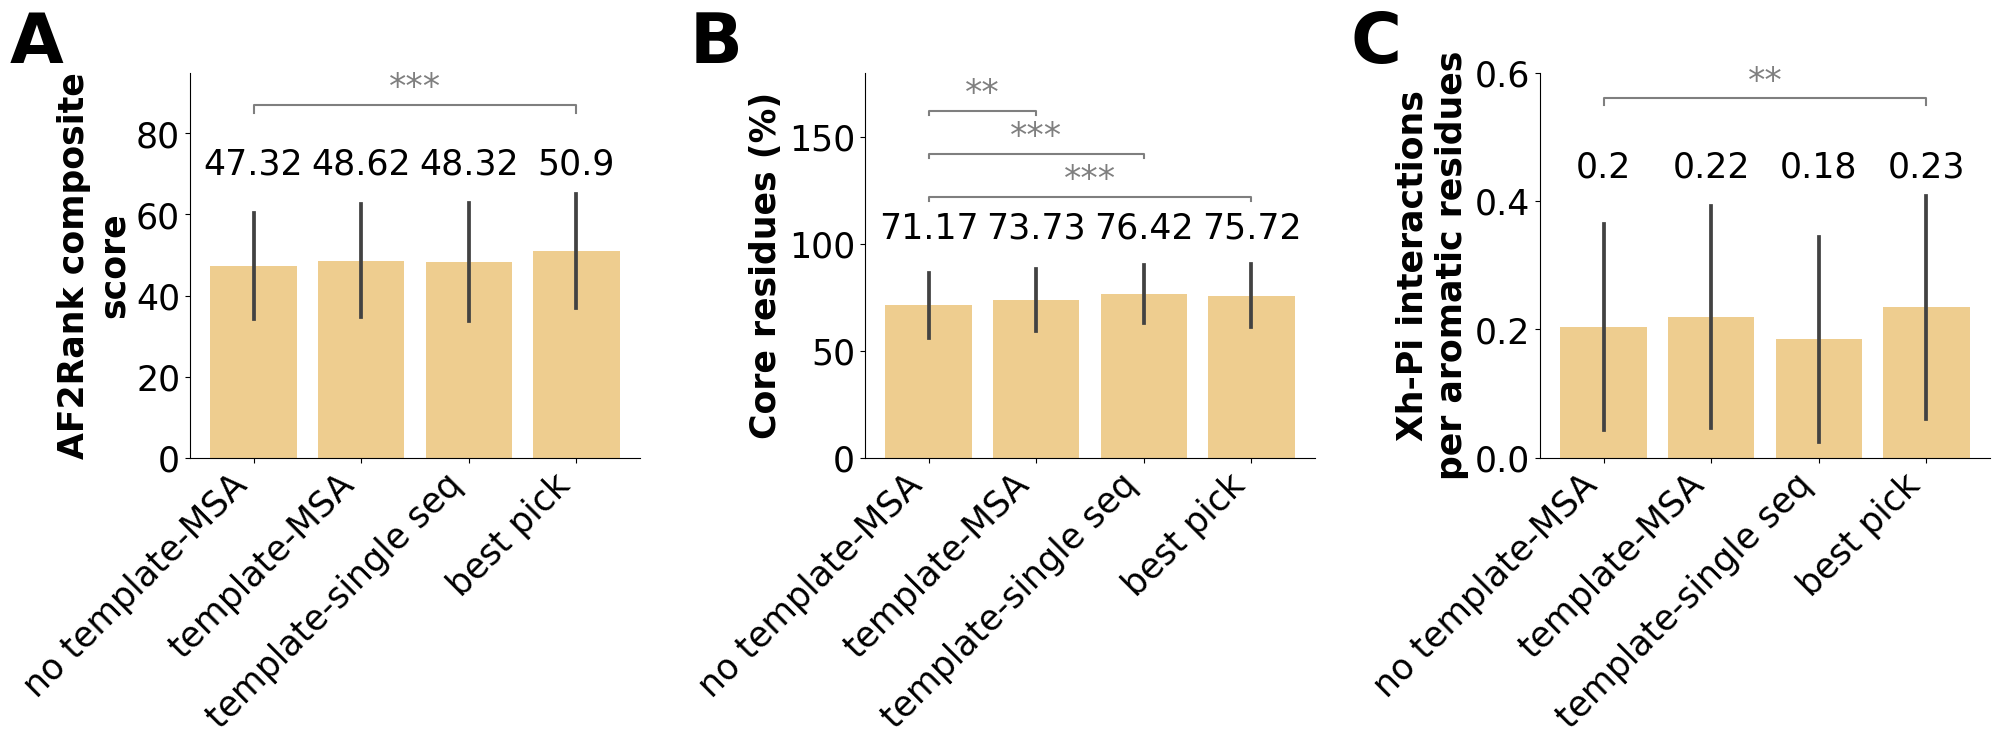

In [31]:
fig, ax = plt.subplots(ncols=3, figsize=[20, 5])
plt.subplots_adjust(hspace=.5, 
                    wspace=.5,
                    left=0,
                    right=.9)
fig.text(-0.09,.9, "A", weight="bold", fontsize=ANNOT_FONT_SIZE)
fig.text(.250,0.9, "B", weight="bold", fontsize=ANNOT_FONT_SIZE)
fig.text(.58,0.9, "C", weight="bold", fontsize=ANNOT_FONT_SIZE)

#1
# consider only improvable proteins

nice_plot2(plot_af2rank, feature='af2rank_composite',ax=ax[0], low_value=85, inspacer=2, interspacer=6, alpha=0.05,mspace=-5,
          condition_pairs=
              [['no_template', 'best_pick'], ['no_template', 'template_single_seq'], 
               ['no_template', 'template_MSA']], color='orange')
ax[0].set_xlabel('')
ax[0].set_ylim([0,95])
ax[0].set_ylabel('AF2Rank composite\nscore')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

#2
nice_plot2(plot_rama, feature='core',ax=ax[1], low_value=120, inspacer=2, interspacer=20, alpha=0.05,mspace=5,
           color='orange')
ax[1].set_xlabel('')
ax[1].set_ylim([0,180])
ax[1].set_ylabel('Core residues (%)')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

#3
nice_plot2(plot_xhpi, feature='Xh-Pi interactions/aromatic residues',ax=ax[2], low_value=.55, mspace=-0.25, inspacer=.01,
           interspacer=.6, alpha=0.03, color='orange')
ax[2].set_xlabel('')
ax[2].set_ylabel('Xh-Pi interactions\nper aromatic residues')
ax[2].set_ylim([0, 0.6])
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)

plt.savefig(os.path.join(FIGURES_DIR, 'figure3.png'), dpi=400,  transparent=False, bbox_inches='tight')


## Figure S3

In [60]:
# analyse MSAs
outlist = []

for pfamA_acc in os.listdir(os.path.join(RESULT_DIR, 'AF2', 'MSAs')):
    for msa in os.listdir(os.path.join(RESULT_DIR, 'AF2', 'MSAs', pfamA_acc)):
        uniprot_acc = msa.replace('.a3m', '')
        msa_path = os.path.join(RESULT_DIR, 'AF2', 'MSAs', pfamA_acc, msa)
        outlist.append([pfamA_acc, uniprot_acc, len(list(SeqIO.parse(msa_path, 'fasta')))])

In [61]:
msa_df = pd.DataFrame(outlist, columns=['pfamA_acc', 'uniprot_acc', 'msa_length'])
msa_df['msa_seqs_norm'] = 0 
for uniprot_acc in msa_df.uniprot_acc.unique():
    pfamA_acc = msa_df[msa_df.uniprot_acc == uniprot_acc].pfamA_acc.unique()[0]
    msa_df.loc[msa_df.uniprot_acc == uniprot_acc, 'msa_seqs_norm'] = msa_df.loc[msa_df.uniprot_acc == uniprot_acc, 'msa_length'] \
        / max(msa_df[msa_df.pfamA_acc == pfamA_acc].msa_length.to_list())

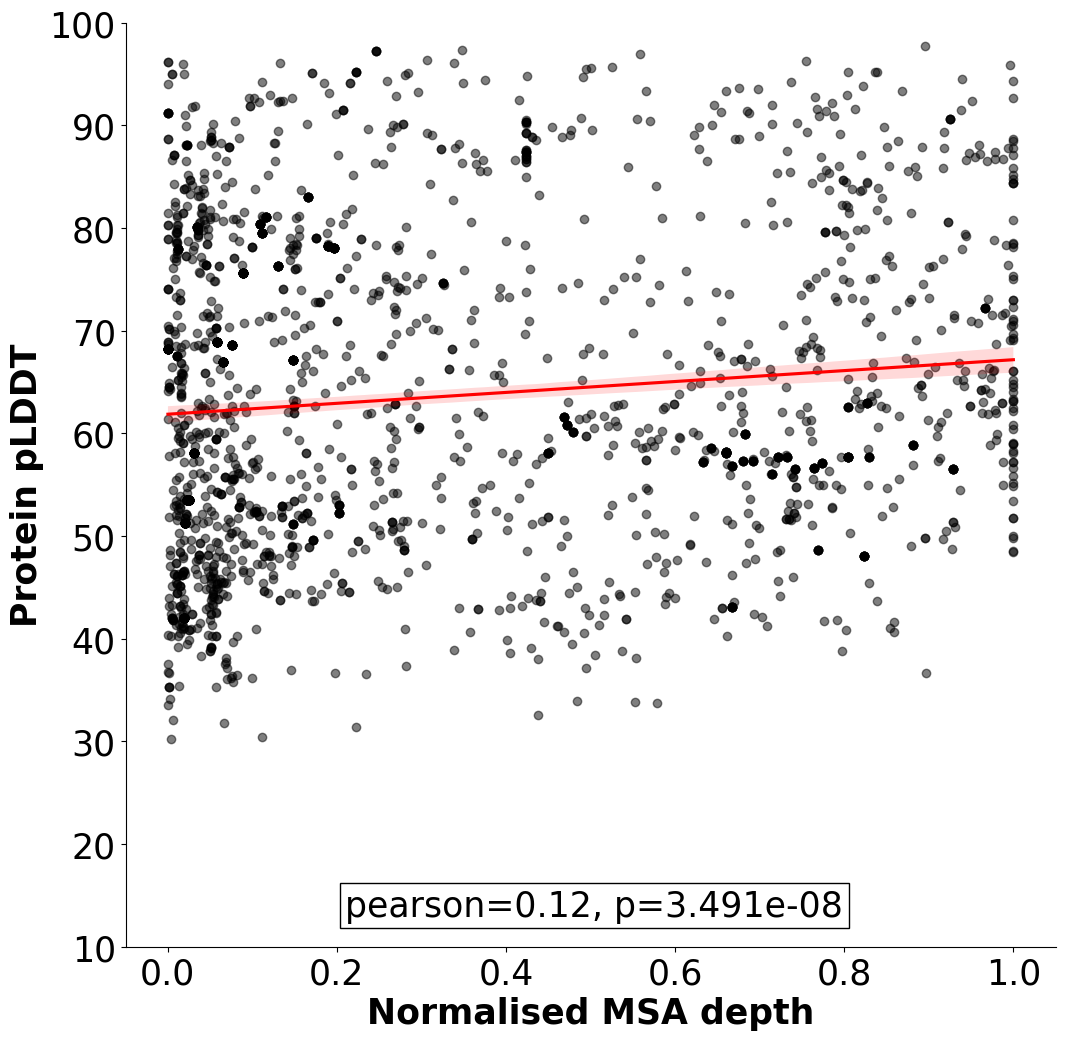

In [63]:
fig, ax = plt.subplots(figsize=[12,12])

plot_df = pd.merge(AF2_df[['uniprot_acc', 'pfamA_acc', 'condition', 'plddt']], msa_df, on=['uniprot_acc', 'pfamA_acc'])
plot_df = plot_df[plot_df.condition == 'no_template']

j = sns.regplot(x='msa_seqs_norm', y='plddt', data=plot_df, ci=95, ax = ax,
                scatter_kws={'alpha':0.5, 'color': 'black'},
                line_kws={'color':"r"})

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

r, p = stats.pearsonr(plot_df.plddt, plot_df.msa_seqs_norm)
ax.text(x=0.21,y=13,s='pearson={:0.2}, p={:0.3e}'.format(r, p),
             bbox=dict(facecolor='none', edgecolor='black'))
plt.xlabel('Normalised MSA depth')
plt.ylabel('Protein pLDDT')
plt.ylim([10,100])
plt.savefig(os.path.join(FIGURES_DIR, 'figureS3.png'), dpi=400, transparent=True, bbox_inches='tight')

## Figure S4

In [12]:
result_dir = Path(RESULT_DIR).joinpath('AF2')

# exclude domains for which only no template data is available
domains_to_exclude = []

df = pd.DataFrame(columns = ['condition', 'pfamA_acc', 'uniprot_acc', 'model', 'recycle', 'plddt', 'ptm', 'tol', 'delta_t'])

for condition in CONDITIONS:
    cond_dir = result_dir.joinpath(condition)
    for p_domain in filter(lambda x: str(x.name).startswith('PF'), cond_dir.iterdir()):
        
        p = p_domain
        pfamA_acc = p_domain.name
        try:    
            logfile = p.joinpath("log.txt")
            tmp_df = get_log_data_wo_relaxation(logfile)
            tmp_df['condition'] = condition
            tmp_df['pfamA_acc'] = pfamA_acc
            df = pd.concat([df, tmp_df])
            
        except Exception as e:
            domains_to_exclude.append(pfamA_acc)
df = df[df.pfamA_acc.isin(domains_to_exclude) == False]

In [13]:
# check what recycle early stop on average

# find the first tol < 0.5 A per model

outlist = []
tmp_df = df[df.recycle != 0]
tol_found = False
#tmp_df = tmp_df.iloc[:20]

for i in range(1, len(tmp_df.index)):
    if tmp_df.iloc[i - 1].model != tmp_df.iloc[i].model:
        tol_found = False

    if tmp_df.iloc[i].tol < 0.5 and tol_found == False:
        outlist.append(tmp_df.iloc[i].to_list())
        tol_found = True
    
    # consider cases in which tol <= .5 was never reached
    if tmp_df.iloc[i].recycle == 5 and tol_found == False:
        outlist.append(tmp_df.iloc[i].to_list())

tol_df = pd.DataFrame(outlist, columns=df.columns)

# safety checks
assert len(df) / 6 == len(tol_df)
assert len(tol_df) == len(tol_df.drop_duplicates())

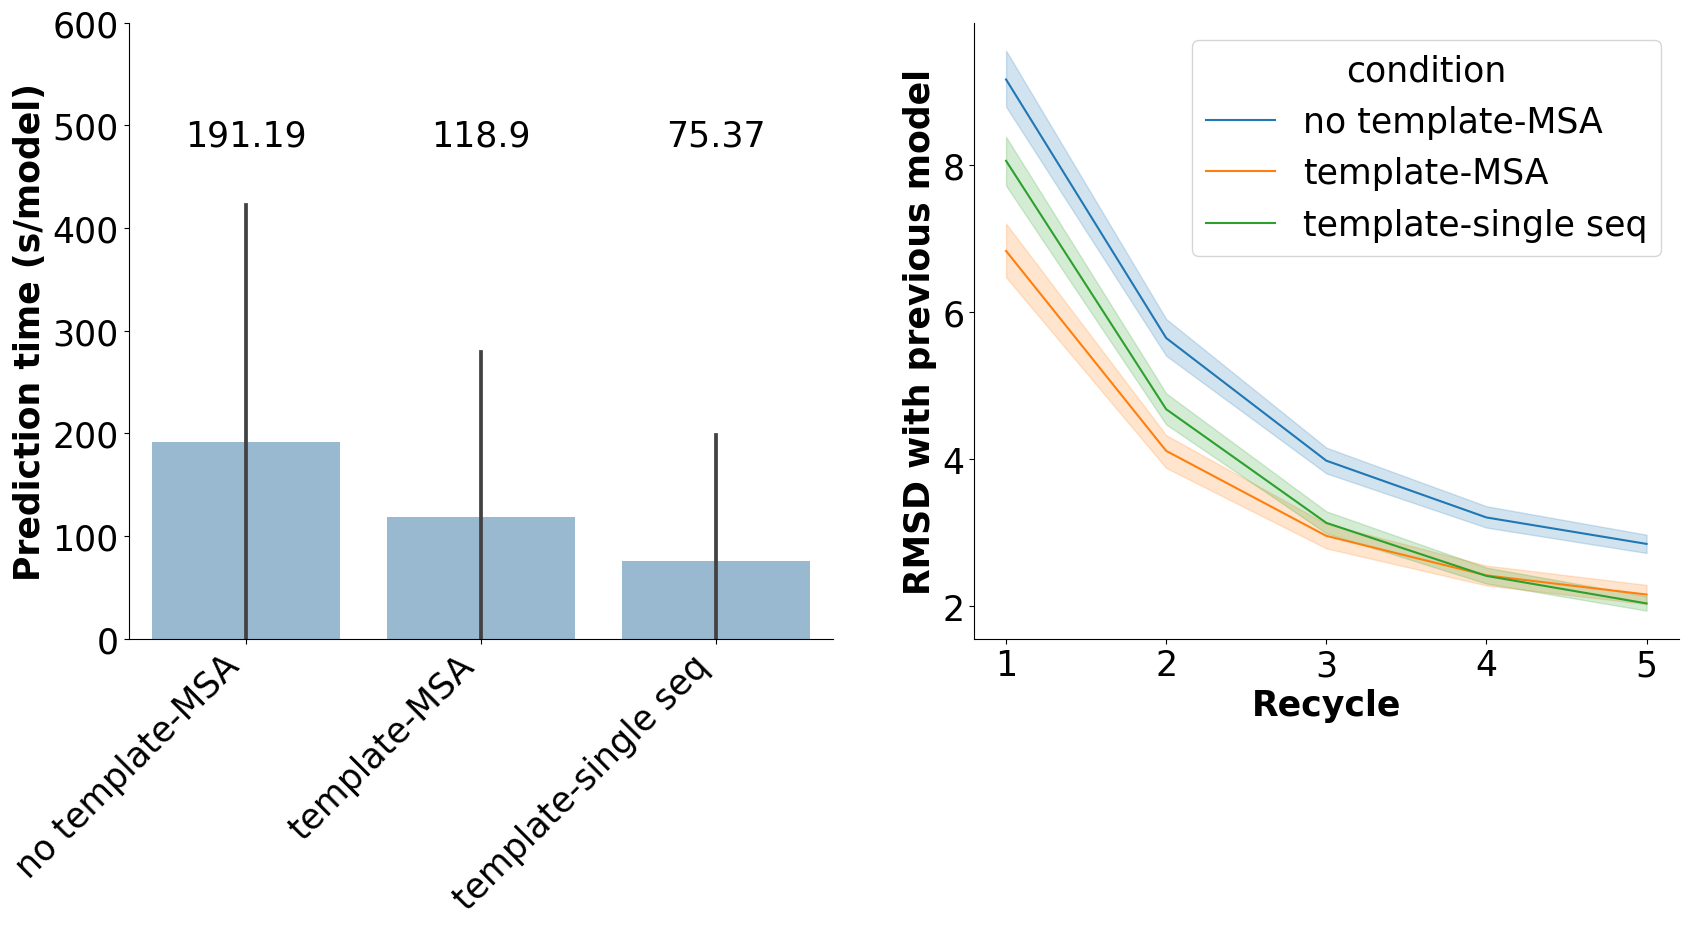

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=[20,8])

#1
plot_df = df[['condition', 'uniprot_acc', 'delta_t', 'recycle']].groupby(['condition', 'uniprot_acc', 'recycle']).mean('delta_t')\
          .groupby(['condition', 'uniprot_acc']).sum('delta_t')
plot_df = plot_df.reset_index()
nice_plot2(plot_df, feature='delta_t', ax=ax[0], low_value=400, inspacer=10, interspacer=50, mspace=-350, stat=False, 
           conditions=['no_template', 'template_MSA', 'template_single_seq'])
ax[0].set_ylim([0,600])
ax[0].set_ylabel("Prediction time (s/model)")
ax[0].set_xlabel('')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

#2

plot_df = df[df.recycle != 0][['condition', 'recycle', 'tol', 'uniprot_acc']].groupby(['condition', 'recycle', 'uniprot_acc']).mean('tol')
plot_df = plot_df.reset_index()
plot_df.condition = plot_df.condition.replace({'no_template': 'no template-MSA', 'template_MSA': 'template-MSA', 'template_single_seq':
                                  'template-single seq'})
plot_df.recycle = plot_df.recycle.astype(int)
sns.lineplot(data=plot_df, x='recycle', y='tol', hue='condition', errorbar='ci', ax=ax[1])
ax[1].set_xticks(range(1,6))
ax[1].set_ylabel('RMSD with previous model')
ax[1].set_xlabel('Recycle')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig(os.path.join(FIGURES_DIR, 'figureS4.png'), dpi=350, transparent=False, bbox_inches='tight')

## Figure S1

In [18]:
df = pd.read_csv(os.path.join(DATA_DIR, "afdb_protein_info.csv"), sep=",")
domains_analysed = df["pfam_id"].unique()[:50]
with open(os.path.join(DATA_DIR, 'distributions.json'), 'r') as handle:
    dist_dic = json.load(handle)
# normalize values
for pfam_id in dist_dic.keys():
    total = total = sum(dist_dic[pfam_id])
    dist_dic[pfam_id] = [dist_dic[pfam_id][i] / total for i in range(100)]

# convert to desired format and filter by domains of interest
outlist = []
for pfamA_acc in dist_dic.keys():
    if pfamA_acc in domains_analysed:
        for plddt, freq in enumerate(dist_dic[pfamA_acc]):
            outlist.append([pfamA_acc, plddt+1, freq])

dist_df = pd.DataFrame(outlist, columns = ["pfamA_acc", "x", "y"])
#dist_df = dist_df.iloc[:4000]

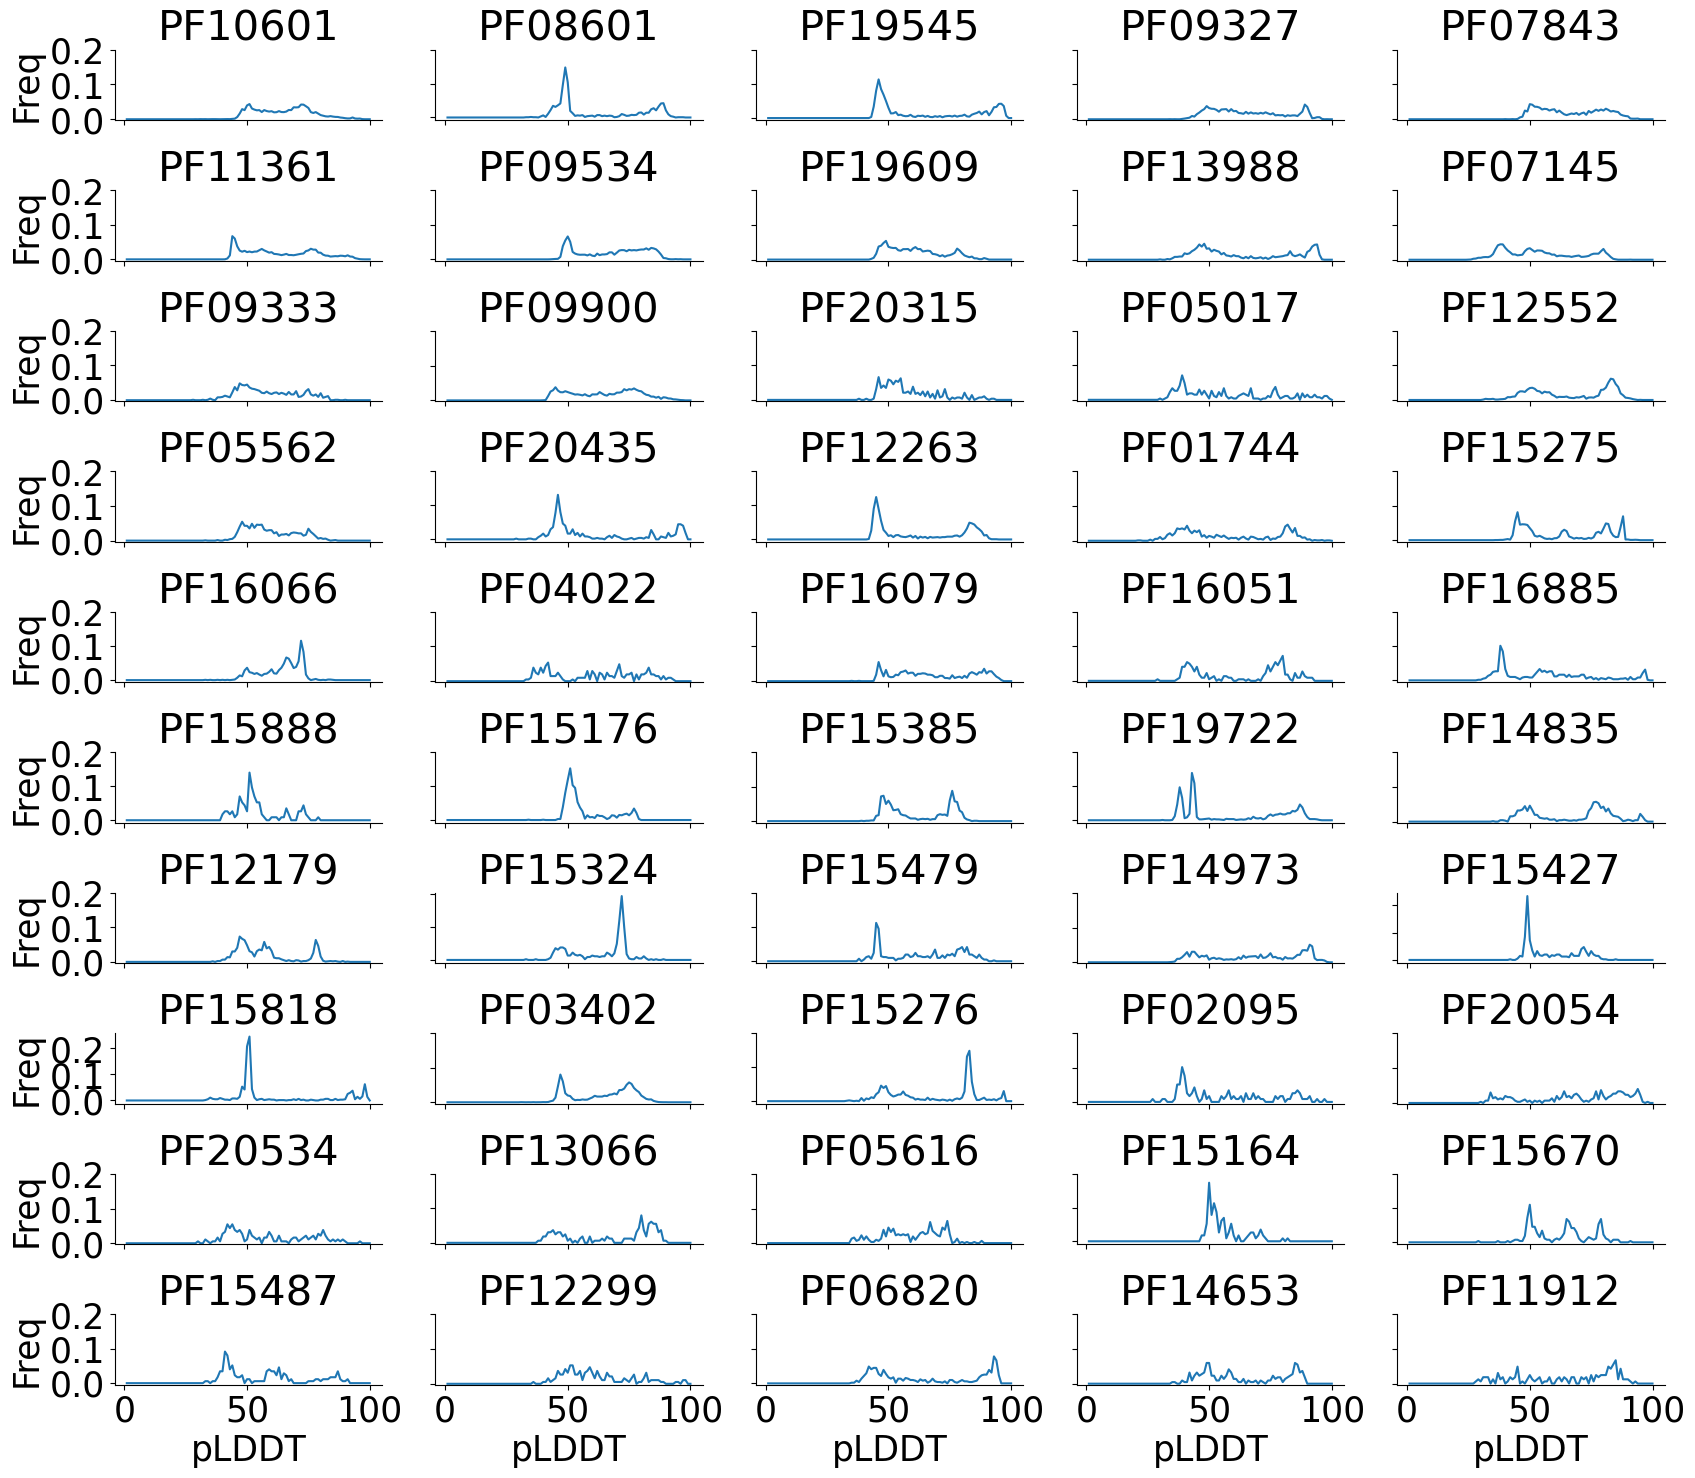

In [19]:
nrows=10
ncols=5

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=[20,15])
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=1)

axes = [[row, col] for row in range(nrows) for col in range(ncols)]
for indx, pfamA_acc in zip(axes, dist_df.pfamA_acc.unique()):
    ax = axs[indx[0], indx[1]]
    x = dist_df[dist_df.pfamA_acc == pfamA_acc]['x']
    y = dist_df[dist_df.pfamA_acc == pfamA_acc]['y']
    ax.plot(x, y)
    ax.set_title(pfamA_acc, weight='normal')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if indx[0] == nrows-1:
        ax.set_xticks([0,50,100])
        ax.set_xlabel("pLDDT", weight="normal")
    else:
       ax.set(xticks=[0,50,100], xlabel="")
       plt.setp(ax.get_xticklabels(), visible=False)
    
    if indx[1] == 0:
        ax.set(yticks=[0,0.1,0.2])
        ax.set_ylabel("Freq", weight="normal")
    else:
        ax.set(yticks=[0,0.1,0.2])
        plt.setp(ax.get_yticklabels(), visible=False)



#g.despine(bottom=True, left=True)
#plt.xlabel("Domain pLDDT",weight="bold")
#plt.ylabel("Frequency", weight="bold")
plt.savefig(os.path.join(FIGURES_DIR, 'figureS1.png'), dpi=400, transparent=True, bbox_inches='tight')
plt.show()